In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message="Ignoring cached namespace 'core'",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message=(
        "invalid value encountered in div "
    ),
    category=RuntimeWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`03_nemos_advanced.ipynb`**. See the button at the top right to download as markdown or pdf.

:::

(sklearn-nb-full)=
# NeMoS Advanced: Cross-Validation and Model Selection


## Learning Objectives

<div class="render-all">


In this tutorial we will keep working on the hippocampal place field recordings with the goal of learning how to combine NeMoS and scikit-learn to perform cross-validation and model selection. In particular we will:

- Learn how to use NeMoS objects with [scikit-learn](https://scikit-learn.org/) for cross-validation
- Learn how to use NeMoS objects with scikit-learn [pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
- Learn how to use cross-validation to perform model and feature selection. More specifically, we will compare models including position and speed as predictors with model including only speed or only position.

</div>


## Pre-Processing

<div class="render-all">

Let's first load and wrangle the data with pynapple and NeMoS. You can run the following cells for preparing the variables that we are going to use in the notebook and recapitulate the content of this dataset with a few visualizations.

</div>

In [2]:
import workshop_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pynapple as nap

import nemos as nmo

# some helper plotting functions
from nemos import _documentation_utils as doc_plots

# configure plots some
plt.style.use(nmo.styles.plot_style)

import workshop_utils

from sklearn import model_selection
from sklearn import pipeline

# shut down jax to numpy conversion warning
nap.nap_config.suppress_conversion_warnings = True

<div class="render-user render-presenter">
- Load the data using pynapple.
</div>

In [3]:
path = workshop_utils.fetch_data("Achilles_10252013_EEG.nwb")
data = nap.load_file(path)
data

Achilles_10252013_EEG
┍━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys        │ Type        │
┝━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units       │ TsGroup     │
│ rem         │ IntervalSet │
│ nrem        │ IntervalSet │
│ forward_ep  │ IntervalSet │
│ eeg         │ TsdFrame    │
│ theta_phase │ Tsd         │
│ position    │ Tsd         │
┕━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙

<div class="render-user render-presenter">
- Extract the spike times and mouse position.
</div>

In [4]:
spikes = data["units"]
position = data["position"]

For today, we're only going to focus on the times when the animal was traversing the linear track. 
This is a pynapple [`IntervalSet`](https://pynapple.org/generated/pynapple.IntervalSet.html), so we can use it to restrict our other variables:

<div class="render-user render-presenter">

- Restrict data to when animal was traversing the linear track.

</div>

In [5]:
position = position.restrict(data["forward_ep"])
spikes = spikes.restrict(data["forward_ep"])

The recording contains both inhibitory and excitatory neurons. Here we will focus of the excitatory cells with firing above 0.3 Hz.

<div class="render-user render-presenter">

- Restrict neurons to only excitatory neurons, discarding neurons with a low-firing rate.

</div>

In [6]:
spikes = spikes.getby_category("cell_type")["pE"]
spikes = spikes.getby_threshold("rate", 0.3)

### Place fields

By plotting the neuronal firing rate as a function of position, we can see that these neurons are all tuned for position: they fire in a specific location on the track.

<div class="render-user render-presenter">

- Visualize the *place fields*: neuronal firing rate as a function of position.
</div>

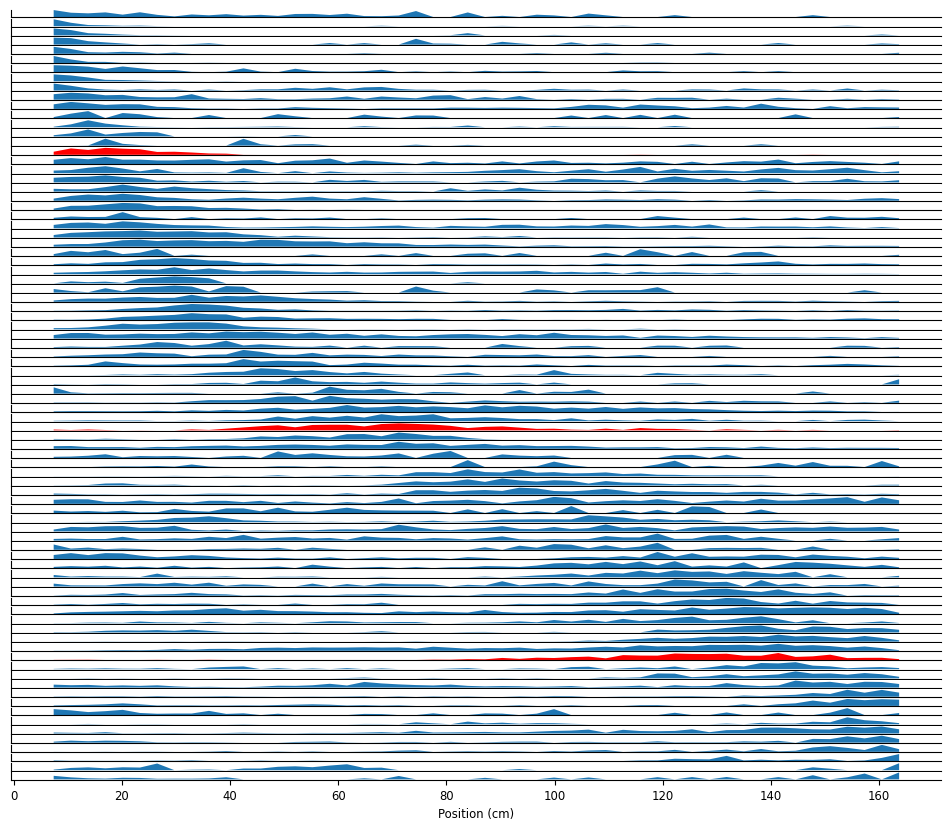

In [7]:
place_fields = nap.compute_tuning_curves(spikes, position, bins=50, epochs=position.time_support, feature_names=["distance"])
workshop_utils.plot_place_fields(place_fields)

To decrease computation time, we're going to spend the rest of the notebook focusing on the neurons highlighted above. We're also going to bin spikes at 100 Hz and up-sample the position to match that temporal resolution.

<div class="render-user render-presenter">

- For speed, we're only going to investigate the three neurons highlighted above.
- Bin spikes to counts at 100 Hz.
- Interpolate position to match spike resolution.

</div>

In [8]:
neurons = [82, 92, 220]
place_fields = place_fields.sel(unit=neurons)
spikes = spikes[neurons]
bin_size = .01
count = spikes.count(bin_size, ep=position.time_support)
position = position.interpolate(count, ep=count.time_support)
print(count.shape)
print(position.shape)

(19237, 3)
(19237,)


### Extract Speed per Epoch

In the next block, we compute the speed of the animal for each epoch (i.e. crossing of the linear track) by taking the temporal derivative of the position. You can use the pynapple method [`derivative`](https://pynapple.org/generated/pynapple.Tsd.derivative.html) that computes an approximate derivative.

<div class="render-user render-presenter">

- Compute the animal's speed.
- Visualize tuning curves to speed and position.

</div>

(19237,)


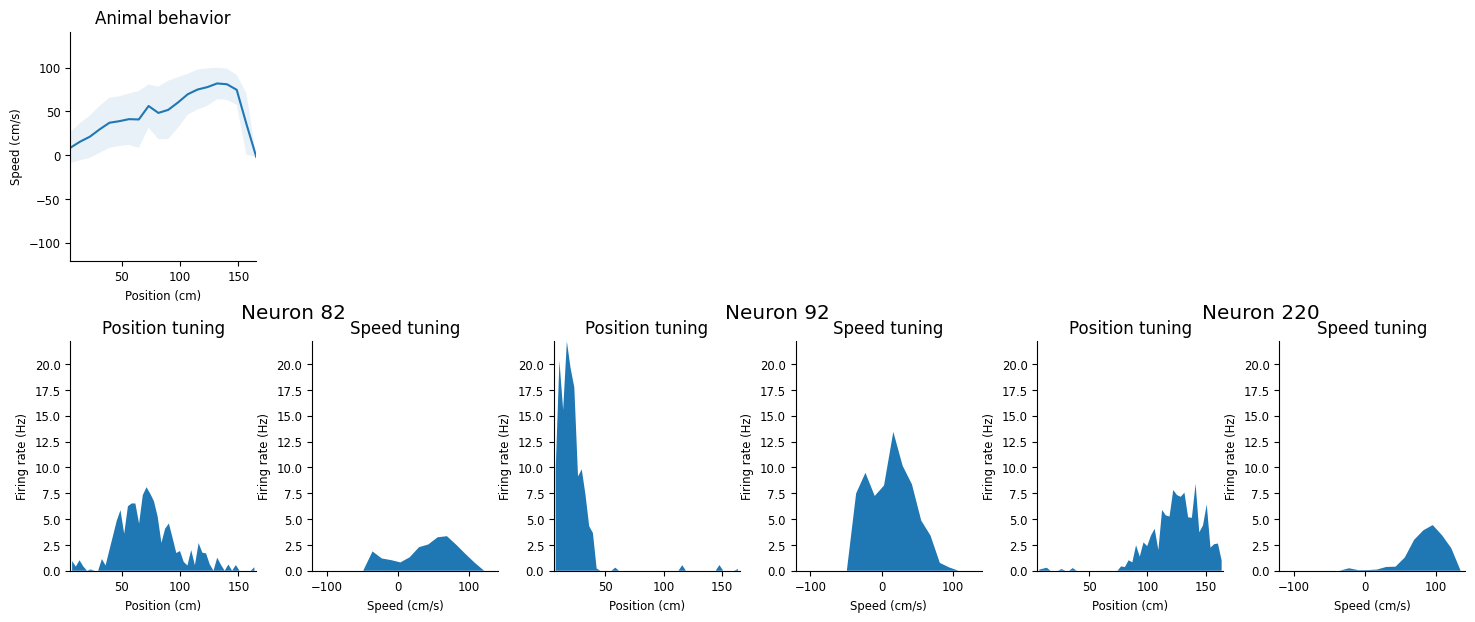

In [9]:
speed = position.derivative()
print(speed.shape)

# utility function to visualize predictions
tc_speed = nap.compute_tuning_curves(spikes, speed, bins=20, epochs=speed.time_support, feature_names=["speed"])
fig = workshop_utils.plot_position_speed(position, speed, place_fields, tc_speed, neurons);

def visualize_model_predictions(glm, X):
    # predict the model's firing rate
    predicted_rate = glm.predict(X) / bin_size

    # compute the position and speed tuning curves using the predicted firing rate.
    glm_pos = nap.compute_tuning_curves(predicted_rate, position, bins=50, epochs=position.time_support, feature_names=["position"])
    glm_speed = nap.compute_tuning_curves(predicted_rate, speed, bins=30, epochs=position.time_support, feature_names=["speed"])

    workshop_utils.plot_position_speed_tuning(place_fields, tc_speed, glm_pos, glm_speed);

### Define 1D NeMoS Bases 

<div class="render-user render-presenter">

- Define the position and speed bases, and visualize them.

</div>

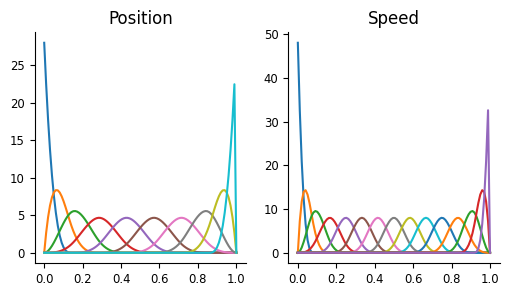

In [10]:
position_basis = nmo.basis.MSplineEval(n_basis_funcs=10, label="position")
speed_basis = nmo.basis.MSplineEval(n_basis_funcs=15, label="speed")
workshop_utils.plot_pos_speed_bases(position_basis, speed_basis);

## Basis Composition

The first new concept we will introduce will be that of basis composition. NeMoS basis can be composed using the "+" (and "*", see [NeMoS docs](https://nemos.readthedocs.io/en/latest/background/basis/plot_02_ND_basis_function.html) of more info) operator, to define more complex predictor. 

Adding two 1D basis, will result in a 2D additive basis. The [`compute_features`](https://nemos.readthedocs.io/en/latest/generated/_basis/nemos.basis._basis.AdditiveBasis.compute_features.html#nemos.basis._basis.AdditiveBasis.compute_features) of the additive basis requires 2 inputs, and the output will be the concatenation of the design matrices of the basis components.


<div class="render-user render-presenter">

- Adding the position and speed bases together defines a 2D basis.
- Call [`compute_features`](https://nemos.readthedocs.io/en/latest/generated/_basis/nemos.basis._basis.AdditiveBasis.compute_features.html#nemos.basis._basis.AdditiveBasis.compute_features) to define a design matrix that concatenates both features.

</div>

<div class="render-user">
```{code-cell} ipython3
# add the bases
basis = 
# get the design matrix
X = 
```
</div>

In [11]:
basis = position_basis + speed_basis

X = basis.compute_features(position, speed)
X_numpy = np.concatenate(
    [
        position_basis.compute_features(position),
        speed_basis.compute_features(speed),
    ],
    axis=1
)

print("Are the design matrices equivalent?", np.all(X.d == X_numpy.d))

Are the design matrices equivalent? True


## Scikit-learn

(sklearn-cv-full)=
### How to know when to regularize?

In the [head direction](head-direction-fit-full) project, we fit the all-to-all connectivity of the head-tuning dataset using the Ridge regularizer, and we learned that regularization can combat overfitting. What we didn't show is how to choose a proper regularizer. Generally, too much regularization leads to underfitting, i.e. the model is too simple and doesn't capture the neural variability well. To little regularization may overfit, especially when we have a large number of parameters, i.e. out model will capture both signal and noise. This is what we saw in the head direction notebook when we used the raw spike history as predictor. 

What we are looking for is a regularization strength that balances out the bias towards simpler models with the variance necessary to explain the data. However, how do we know how much we should regularize? One thing we can do is use cross-validation to see whether model performance on unseen data improves with regularization (behind the scenes, this is what we did!). We'll walk through how to do that now.

Instead of implementing our own cross-validation machinery, the developers of nemos decided that we should write the package to be compliant with [scikit-learn](https://scikit-learn.org), the canonical machine learning python library. Our models are all what scikit-learn calls "estimators", which means they have `.fit`, `.score.` and `.predict` methods. Thus, we can use them with scikit-learn's objects out of the box.

We're going to use scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) object, which performs a cross-validated grid search, as [Edoardo explained in his presentation](https://users.flatironinstitute.org/~wbroderick/presentations/sfn-2025/model_selection.pdf).

This object requires an estimator, our `glm` object here, and `param_grid`, a dictionary defining what to check. For now, let's just compare Ridge regularization at two different strengths:

<div class="render-user render-presenter">

- How do we decide when to use regularization?
- Cross-validation allows you to fairly compare different models on the same dataset.
- NeMoS makes use of [scikit-learn](https://scikit-learn.org/), the standard machine learning library in python.
- Define [parameter grid](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to search over.
- Anything not specified in grid will be kept constant.

</div>

<div class="render-user">
```{code-cell} ipython3
# configurations of the PopulationGLM
solver_kwargs={"tol": 1e-12}
solver_name="LBFGS"
# define a Ridge regularized PopulationGLM
glm =
```
</div>

In [12]:
# define a Ridge PopulationGLM
glm = nmo.glm.PopulationGLM(
    regularizer="Ridge",
    solver_kwargs={"tol": 1e-12},
    solver_name="LBFGS",
)
param_grid = {
    "regularizer_strength": [0.0001, 1.],
}

<div class="render-user render-presenter">

- Initialize scikit-learn's [`model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) object. 

</div>

<div class="render-user">
```{code-cell} ipython3
cv_folds = 5
cv = 
cv
```
</div>

In [13]:
cv_folds = 5
cv = model_selection.GridSearchCV(glm, param_grid, cv=cv_folds)
cv

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",PopulationGLM...tol': 1e-12} )
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'regularizer_strength': [0.0001, 1.0]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and can

This will take a bit to run, because we're fitting the model many times!

<div class="render-user render-presenter">

- We interact with this in a very similar way to the glm object.
- In particular, call `fit` with same arguments:
</div>

In [14]:
cv.fit(X, count)

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",PopulationGLM...tol': 1e-12} )
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'regularizer_strength': [0.0001, 1.0]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and can

<div class="render-user render-presenter">

- Let's investigate results:
</div>

Cross-validation results are stored in a dictionary attribute called `cv_results_`, which contains a lot of info. Let's convert that to a pandas dataframe for readability,

In [15]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regularizer_strength,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.752710,0.703769,0.369165,0.446579,0.0001,{'regularizer_strength': 0.0001},-0.127700,-0.118069,-0.161886,-0.131911,-0.125092,-0.132931,0.015160,1
1,2.955397,2.484815,0.005835,0.001442,1.0000,{'regularizer_strength': 1.0},-0.137128,-0.128441,-0.173226,-0.138692,-0.131281,-0.141753,0.016175,2


The most informative for us is the `'mean_test_score'` key, which shows the average of `glm.score` on each test-fold. Thus, higher is better, and we can see that the model performs better with lower regularization strength.

:::{admonition} Find the best regularization strength!
:class: important render-all

As an exercise, spend 10 minutes trying to find the best regularization strength!

- You should use the `glm` model we defined in this section.
- You will need to redefine the `param_grid` dictionary, selecting different values for `"regularizer_strength"`:

```{code-block} python
param_grid = {
    "regularizer_strength": ...,
}
```

- After defining `param_grid`, reinitialize `cv` (you can do so with the same arguments).
- Then call `cv.fit` and re-run `pd.DataFrame(cv.cv_results_)` to summarize the results.

Who can find the best regularization strength?

If you finish early, try out different regularizers and try to find the best regularization strength for each of them.

:::

(sklearn-basis-full)=
### Select basis

We can do something similar to select the basis. In the above example, I just told you which basis function to use and how many of each. But, in general, you want to select those in a reasonable manner. Cross-validation to the rescue!

Unlike the glm objects, our basis objects are not scikit-learn compatible right out of the box. However, they can be made compatible by using the [`.to_transformer()`](https://nemos.readthedocs.io/en/latest/generated/_basis/nemos.basis._basis.AdditiveBasis.to_transformer.html#nemos.basis._basis.AdditiveBasis.to_transformer) method (or, equivalently, by using the [`TransformerBasis`](https://nemos.readthedocs.io/en/latest/generated/_transformer_basis/nemos.basis._transformer_basis.TransformerBasis.html#nemos.basis._transformer_basis.TransformerBasis) class)

<div class="render-user render-presenter">

- You can (and should) do something similar to determine how many basis functions you need for each input.
- NeMoS basis objects are not scikit-learn-compatible right out of the box.
- But we have provided a simple method to make them so:

</div>


<div class="render-user">
```{code-cell} ipython3
# convert basis to transformer
position_basis = 
position_basis
```
</div>

In [16]:
position_basis = nmo.basis.MSplineEval(n_basis_funcs=10, label="position").to_transformer()
# or equivalently:
position_basis = nmo.basis.TransformerBasis(nmo.basis.MSplineEval(n_basis_funcs=10, label="position"))
position_basis

,n_basis_funcs,10
,order,4
,bounds,None
,label,'position'


This gives the basis object the [`transform`](https://nemos.readthedocs.io/en/latest/generated/_transformer_basis/nemos.basis._transformer_basis.TransformerBasis.transform.html#nemos.basis._transformer_basis.TransformerBasis.transform) method, which is equivalent to `compute_features`. However, transformers have some limits:

<div class="render-user render-presenter">

- This gives the basis object the [`transform`](https://nemos.readthedocs.io/en/latest/generated/_transformer_basis/nemos.basis._transformer_basis.TransformerBasis.transform.html#nemos.basis._transformer_basis.TransformerBasis.transform) method, which is equivalent to `compute_features`.
- However, transformers have some limits:

</div>

In [17]:
position_basis.transform(position)

ValueError: X must be 2-dimensional, shape (n_samples, n_features). The provided X has shape (19237,) instead.

<div class="render-user render-presenter">

- Transformers only accept 2d inputs, whereas nemos basis objects can accept inputs of any dimensionality.
- In order to use a basis as a transformer, you'll need to concatenate all your input in a single 2D array.

</div>

Transformers only accept 2d inputs, whereas nemos basis objects can accept inputs of any dimensionality.

In [18]:
position_basis.transform(position[:, np.newaxis])

Time (s)                0           1            2            3    4  ...
---------------  --------  ----------  -----------  -----------  ---  -----
18193.603802655  0.162854  0.0063002   5.33261e-05  1.12053e-07    0  ...
18193.613802655  0.159556  0.00790116  8.52389e-05  2.27854e-07    0  ...
18193.623802655  0.156303  0.00946868  0.000124421  4.04332e-07    0  ...
18193.633802655  0.151106  0.0119478   0.000203448  8.54051e-07    0  ...
18193.643802655  0.145902  0.014398    0.000303689  1.57397e-06    0  ...
18193.653802655  0.141967  0.0162281   0.000394145  2.34623e-06    0  ...
18193.663802655  0.139957  0.0171555   0.000445419  2.8306e-06     0  ...
...                                                                   ...
20123.332682821  0         0           0            0              0  ...
20123.342682821  0         0           0            0              0  ...
20123.352682821  0         0           0            0              0  ...
20123.362682821  0         0        

<div class="render-all">

:::{dropdown} Other Caveats
:color: info
:icon: info


If the basis has more than one component (for example, if it is the addition of two 1D bases), the transformer will expect an input shape of `(n_sampels, 1)` pre component. If that's not the case, you'll provide a different input shape by calling `set_input_shape`.

**Case 1)** One input per component:

```{code-block} python
# generate a composite basis
basis_2d = nmo.basis.MSplineEval(5) + nmo.basis.MSplineEval(5)
basis_2d = basis_2d.to_transformer()

# this will work: 1 input per component
x, y = np.random.randn(10, 1), np.random.randn(10, 1)
X = np.concatenate([x, y], axis=1)
result = basis_2d.transform(X)
```

**Case 2)** Multiple inputs per component.


- If one or more basis process multiple inputs (multiple columns of the 2D array), trying to call the [`transform`](https://nemos.readthedocs.io/en/latest/generated/_transformer_basis/nemos.basis._transformer_basis.TransformerBasis.transform.html#nemos.basis._transformer_basis.TransformerBasis.transform) method directly will lead to an error. 
- This is because the basis doesn't know which component should process which column. 


```{code-block} python

# Assume 2 input for the first component and 3 for the second.
x, y = np.random.randn(10, 2), np.random.randn(10, 3)
X = np.concatenate([x, y], axis=1)

res = basis_2d.transform(X)  # This will raise an exception!
```

To prevent that, use `set_input_shape` to define how many inputs each component should process.

```{code-block} python
# Set the expected input shape instead, different options:

# array
res1 = basis_2d.set_input_shape(x, y).transform(X)
# int
res2 = basis_2d.set_input_shape(2, 3).transform(X)
# tuple
res3 = basis_2d.set_input_shape((2,), (3,)).transform(X)
```

:::


- Let's now create the composite basis for speed and position.

</div>


<div class="render-user">
```{code-cell} ipython3
# redefine the basis with label="position"
position_basis =
# redefine the basis with label="speed"
speed_basis = nmo.basis.MSplineEval(n_basis_funcs=15, label="speed")
basis = position_basis + speed_basis
# convert to transformer
basis = 
basis
```
</div>

In [19]:
position_basis = nmo.basis.MSplineEval(n_basis_funcs=10, label="position")
speed_basis = nmo.basis.MSplineEval(n_basis_funcs=15, label="speed")
basis = position_basis + speed_basis
basis = basis.to_transformer()
basis

,label,'(position + speed)'
,position__bounds,None
,position__label,'position'
,position__n_basis_funcs,10
,position__order,4
,position,"'position': M...s=10, order=4)"
,speed__bounds,None
,speed__label,'speed'
,speed__n_basis_funcs,15
,speed__order,4
,speed,"'speed': MSpl...s=15, order=4)"


Let's create a single TsdFrame to hold all our inputs:

<div class="render-user render-presenter">

- Stack position and speed in a single TsdFrame to hold all our inputs:

</div>

In [20]:
transformer_input = nap.TsdFrame(
    t=position.t,
    d=np.stack([position, speed]).T,
    time_support=position.time_support,
    columns=["position", "speed"],
)

<div class="render-user render-presenter">

- Pass this input to our transformed additive basis.

</div>

Our new additive transformer basis can then take these behavioral inputs and turn them into the model's design matrix.

In [21]:
basis.transform(transformer_input)

Time (s)                0           1            2            3    4  ...
---------------  --------  ----------  -----------  -----------  ---  -----
18193.603802655  0.162854  0.0063002   5.33261e-05  1.12053e-07    0  ...
18193.613802655  0.159556  0.00790116  8.52389e-05  2.27854e-07    0  ...
18193.623802655  0.156303  0.00946868  0.000124421  4.04332e-07    0  ...
18193.633802655  0.151106  0.0119478   0.000203448  8.54051e-07    0  ...
18193.643802655  0.145902  0.014398    0.000303689  1.57397e-06    0  ...
18193.653802655  0.141967  0.0162281   0.000394145  2.34623e-06    0  ...
18193.663802655  0.139957  0.0171555   0.000445419  2.8306e-06     0  ...
...                                                                   ...
20123.332682821  0         0           0            0              0  ...
20123.342682821  0         0           0            0              0  ...
20123.352682821  0         0           0            0              0  ...
20123.362682821  0         0        

### Pipelines

We need one more step: scikit-learn cross-validation operates on an estimator, like our GLMs. if we want to cross-validate over the basis or its features, we need to combine our transformer basis with the estimator into a single estimator object. Luckily, scikit-learn provides tools for this: pipelines.

Pipelines are objects that accept a series of (0 or more) transformers, culminating in a final estimator. This is defined as a list of tuples, with each tuple containing a human-readable label and the object itself:

<div class="render-user render-presenter">

- If we want to cross-validate over the basis, we need more one more step: combining the basis and the GLM into a single scikit-learn estimator.
- [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to the rescue!

</div>

<div class="render-user">
```{code-cell} ipython3
# set the reg strength to the optimal
glm = 
# pipe the basis and the glm
pipe = pipeline.Pipeline(
pipe
```
</div>

In [22]:
# set the reg strength to the optimal
glm = nmo.glm.PopulationGLM(solver_name="LBFGS", solver_kwargs={"tol": 10**-12})
pipe = pipeline.Pipeline([
    ("basis", basis),
    ("glm", glm)
])
pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('basis', ...), ('glm', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,label,'(position + speed)'
,position__bounds,None
,position__label,'position'
,position__n_basis_funcs,10
,position__order,4
,position,"'position': M...s=10, order=4)"
,speed__bounds,None


This pipeline object allows us to e.g., call fit using the *initial input*:

<div class="render-user render-presenter">

- Pipeline runs `basis.transform`, then passes that output to `glm`, so we can do everything in a single line:
</div>

In [23]:
pipe.fit(transformer_input, count)

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('basis', ...), ('glm', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,label,'(position + speed)'
,position__bounds,None
,position__label,'position'
,position__n_basis_funcs,10
,position__order,4
,position,"'position': M...s=10, order=4)"
,speed__bounds,None


We then visualize the predictions the same as before, using `pipe` instead of `glm`.

<div class="render-user render-presenter">

- Visualize model predictions!

</div>

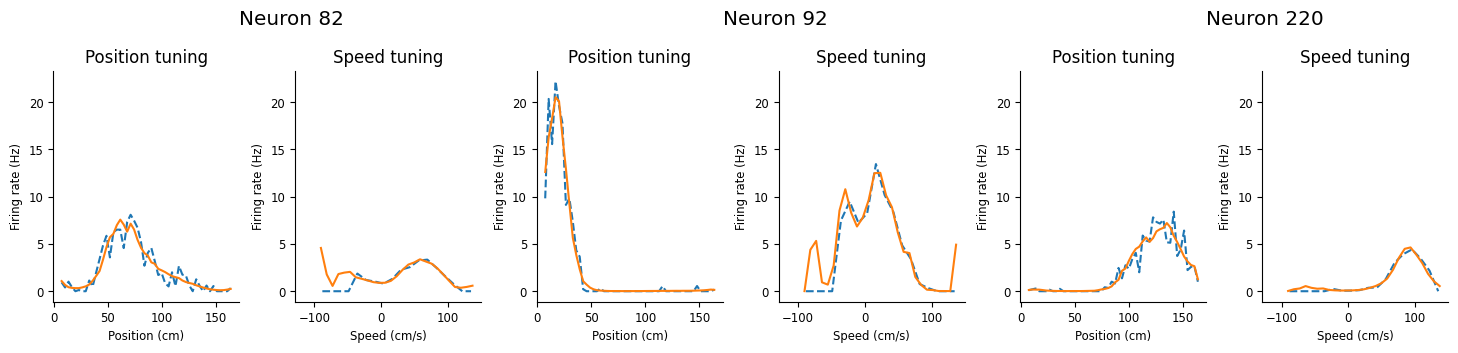

In [24]:
visualize_model_predictions(pipe, transformer_input)

### Cross-validating on the basis

<div class="render-all">

Now that we have our pipeline estimator, we can cross-validate on any of its parameters!

</div>

In [25]:
pipe.steps

[('basis',
  Transformer('(position + speed)': AdditiveBasis(
      basis1='position': MSplineEval(n_basis_funcs=10, order=4),
      basis2='speed': MSplineEval(n_basis_funcs=15, order=4),
  ))),
 ('glm',
  PopulationGLM(
      observation_model=PoissonObservations(),
      inverse_link_function=exp,
      regularizer=UnRegularized(),
      solver_name='LBFGS',
      solver_kwargs={'tol': 1e-12}
  ))]

Let's cross-validate on the number of basis functions for the position basis, and the identity of the basis for the speed. That is:

<div class="render-user render-presenter">

Let's cross-validate on:
- The number of the basis functions of the position basis
- The functional form of the basis for speed
- Let's retrieve the those attributes from the pipeline
</div>

In [26]:
# the label of the pipeline step retrieves the basis
print(pipe["basis"])

# the position basis can by retreived by its label
print("\n", pipe["basis"]["position"])

# the n_basis_funcs is an attribute
print("\n", pipe["basis"]["position"].n_basis_funcs)

# with the same syntax we can retreive the speed basis
print("\n", pipe["basis"]["speed"])

Transformer('(position + speed)': AdditiveBasis(
    basis1='position': MSplineEval(n_basis_funcs=10, order=4),
    basis2='speed': MSplineEval(n_basis_funcs=15, order=4),
))

 Transformer('position': MSplineEval(n_basis_funcs=10, order=4))

 10

 Transformer('speed': MSplineEval(n_basis_funcs=15, order=4))


For scikit-learn parameter grids, we use `__` to stand in for `.`:

<div class="render-user render-presenter">

- Construct `param_grid`, using `__` to stand in for `.`
- In scikit-learn pipelines, we access nested parameters using double underscores:
  - `pipe["basis"]["position"].n_basis_funcs` - normal Python syntax
  - `"basis__position__n_basis_funcs"` - scikit-learn parameter grid syntax

</div>

<div class="render-user">
```{code-cell} ipython3
param_grid = 
```
</div>

In [27]:
param_grid = {
    "basis__position__n_basis_funcs": [5, 10, 20],
    "basis__speed": [nmo.basis.MSplineEval(15),
                      nmo.basis.BSplineEval(15),
                      nmo.basis.RaisedCosineLinearEval(15)],
}

<div class="render-user render-presenter">

- Cross-validate as before:

</div>

<div class="render-user">
```{code-cell} ipython3
# define the grid search and fit
cv =
```
</div>

In [28]:
cv = model_selection.GridSearchCV(pipe, param_grid, cv=cv_folds)
cv.fit(transformer_input, count)

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...me='LBFGS'))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'basis__position__n_basis_funcs': [5, 10, ...], 'basis__speed': [MSplineEval(n...s=15, order=4), BSplineEval(n...s=15, order=4), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold

<div class="render-user render-presenter">

- Investigate results:

</div>

In [29]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_basis__position__n_basis_funcs,param_basis__speed,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.913792,0.686408,0.526917,0.541533,5,"(((MSplineEval(n_basis_funcs=15, order=4))))","{'basis__position__n_basis_funcs': 5, 'basis__...",-0.136246,-0.116545,-0.147549,-0.122671,-0.128592,-0.130321,0.010800,3
1,1.467798,0.245492,0.041434,0.006860,5,"(((BSplineEval(n_basis_funcs=15, order=4))))","{'basis__position__n_basis_funcs': 5, 'basis__...",-0.150079,-0.155905,-0.172195,-0.126545,-0.198609,-0.160667,0.023965,8
2,1.488027,0.217582,0.146714,0.131834,5,"(((RaisedCosineLinearEval(n_basis_funcs=15, wi...","{'basis__position__n_basis_funcs': 5, 'basis__...",-0.163750,-0.128224,-0.184139,-0.125410,-0.216403,-0.163585,0.034409,9
3,1.603927,0.187472,0.138269,0.050610,10,"(((MSplineEval(n_basis_funcs=15, order=4))))","{'basis__position__n_basis_funcs': 10, 'basis_...",-0.127216,-0.113708,-0.148560,-0.122756,-0.132335,-0.128915,0.011573,2
4,1.613850,0.255640,0.059732,0.011073,10,"(((BSplineEval(n_basis_funcs=15, order=4))))","{'basis__position__n_basis_funcs': 10, 'basis_...",-0.153041,-0.131869,-0.165941,-0.123137,-0.176732,-0.150144,0.020141,6
5,1.525249,0.141245,0.059565,0.006274,10,"(((RaisedCosineLinearEval(n_basis_funcs=15, wi...","{'basis__position__n_basis_funcs': 10, 'basis_...",-0.148822,-0.126507,-0.168947,-0.122744,-0.168339,-0.147072,0.019742,4
6,1.884204,0.379766,0.291943,0.190977,20,"(((MSplineEval(n_basis_funcs=15, order=4))))","{'basis__position__n_basis_funcs': 20, 'basis_...",-0.126687,-0.112765,-0.146401,-0.124083,-0.123058,-0.126599,0.010976,1
7,1.719641,0.304256,0.108181,0.008016,20,"(((BSplineEval(n_basis_funcs=15, order=4))))","{'basis__position__n_basis_funcs': 20, 'basis_...",-0.153473,-0.132539,-0.167847,-0.124594,-0.179855,-0.151662,0.020777,7
8,1.607184,0.140240,0.100813,0.013484,20,"(((RaisedCosineLinearEval(n_basis_funcs=15, wi...","{'basis__position__n_basis_funcs': 20, 'basis_...",-0.146942,-0.128252,-0.172728,-0.124165,-0.167277,-0.147873,0.019709,5


scikit-learn does not cache every model that it runs (that could get prohibitively large!), but it does store the best estimator, as the appropriately-named `best_estimator_`.

<div class="render-user render-presenter">

- Can easily grab the best estimator, the pipeline that did the best:

</div>

<div class="render-user">
```{code-cell} ipython3
# define the grid search and fit
best_estim =
best_estim
```
</div>

In [30]:
best_estim = cv.best_estimator_
best_estim

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('basis', ...), ('glm', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,label,'(position + speed)'
,position__bounds,None
,position__label,'position'
,position__n_basis_funcs,20
,position__order,4
,position,"'position': M...s=20, order=4)"
,speed__bounds,None


We then visualize the predictions of `best_estim` the same as before.

<div class="render-user render-presenter">

- Visualize model predictions!

</div>

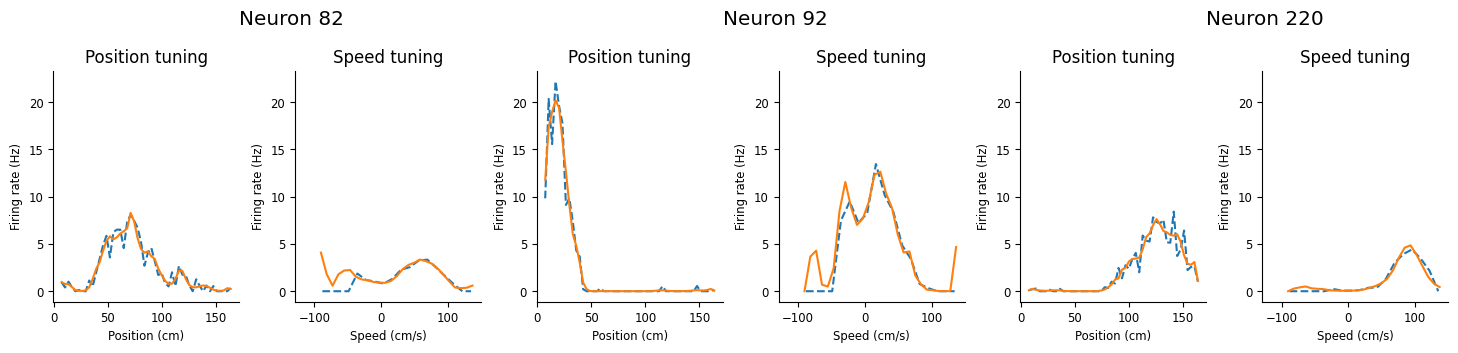

In [31]:
visualize_model_predictions(best_estim, transformer_input)

:::{admonition} Find the best basis!
:class: important render-all

As an exercise, spend 10 minutes exploring the possible basis objects and seeing which performs the best.

- You should use the `pipe` object we defined in this section.
- You will need to redefine the `param_grid` dictionary, setting `basis__speed` and `basis__position` (or their attributes, e.g., `basis__position__n_basis_funcs`) to a range of values. Remember that all combinations are tested, so if you e.g., select 5 choices for each, you'll be testing 25 different combinations!

```{code-block} python
param_grid = {
    "basis__position": ...,
    "basis__speed": ...,
}

```
- After defining `param_grid`, reinitialize `cv` (you can do so with the same arguments).
- Then call `cv.fit` and re-run `pd.DataFrame(cv.cv_results_)` to summarize the results.
- Finally, visualize the best estimator with `visualize_model_predictions(cv.best_estimator_, transformer_input)`

Who can find the best set of basis objects?

:::

(sklearn-feature-selection-full)=
## Feature selection

Now that we understand how scikit-learn works with NeMoS, we can determine whether both position and speed are necessary inputs by performing feature selection. 

Our goal is to compare alternative models: position + speed, position only, or speed only. However, scikit-learn's cross-validation assumes that the input to the pipeline stays constant—only the hyperparameters change. So how can we compare models that require different features?

Here's a clever NeMoS trick: we'll create a "null" basis that produces zero features. This way, all models take the same 2-D input (position, speed), but some features become empty arrays. We can define this null basis using [`CustomBasis`](https://nemos.readthedocs.io/en/latest/generated/_custom_basis/nemos.basis._custom_basis.CustomBasis.html#nemos.basis._custom_basis.CustomBasis), which creates a basis from a list of functions.

<div class="render-user render-presenter">

Let's move on to feature selection. Our goal is to compare alternative models: position + speed, position only, or speed only.

Problem: scikit-learn's cross-validation assumes the pipeline input stays constant, but each model needs different features. How do we solve this?

Solution: Use a "null" basis that produces zero features!

- We'll create this null basis using [`CustomBasis`](https://nemos.readthedocs.io/en/latest/generated/_custom_basis/nemos.basis._custom_basis.CustomBasis.html#nemos.basis._custom_basis.CustomBasis), which defines a basis from custom functions.

</div>

<div class="render-user">
```{code-cell} ipython3
# define a function that creates an empty array (n_samples, 0)
def func(x):
    return np.zeros((x.shape[0], 0))
# create a null transformer basis using the custom basis class
null_basis =
# verify: this creates an empty feature array
null_basis.compute_features(position).shape
```
</div>

In [32]:
# define a function that creates an empty array (n_samples, 0)
def func(x):
    return np.zeros((x.shape[0], 0))

# create a null transformer basis using the custom basis class
null_basis = nmo.basis.CustomBasis([func]).to_transformer()

# verify: this creates an empty feature array
null_basis.compute_features(position).shape

(19237, 0)

<div class="render-user render-presenter">

Why is this useful? We can combine `null_basis` with actual bases to create different models that all accept the same input!

Let's define the bases for our three models:
- Position + speed: combine position and speed bases
- Position only: combine position basis with null basis (speed features is empty)
- Speed only: combine null basis with speed basis (position features is empty)

</div>

<div class="render-user">
```{code-cell} ipython3
# combine them to define each model
basis_all = 
basis_position = 
basis_speed =
# assign labels (optional but helpful for readability)
basis_all.label = "position + speed"
basis_position.label = "position only"
basis_speed.label = "speed only"
```
</div>

In [33]:
# combine them to define each model
basis_all = (position_basis + speed_basis).to_transformer()
basis_position = (position_basis + null_basis).to_transformer()
basis_speed = (null_basis + speed_basis).to_transformer()

# assign labels (optional but helpful for readability)
basis_all.label = "position + speed"
basis_position.label = "position only"
basis_speed.label = "speed only"

<div class="render-user render-presenter">

These bases can all transform the same `transformer_input` (a `TsdFrame` with columns for position and speed), but they generate design matrices with different numbers of features:

</div>

In [34]:
# "position + speed" design: 25 features (10 + 15)
print("position + speed design matrix shape:")
print(basis_all.transform(transformer_input).shape)

# "position" design: 10 features (10 + 0)
print("\nposition design matrix shape:")
print(basis_position.transform(transformer_input).shape)

# "speed" design: 15 features (0 + 15)
print("\nspeed design matrix shape:")
print(basis_speed.transform(transformer_input).shape)

position + speed design matrix shape:
(19237, 25)

position design matrix shape:
(19237, 10)

speed design matrix shape:
(19237, 15)


<div class="render-user render-presenter">

To cross-validate over different basis compositions, we need to understand how they're stored in our pipeline. The additive basis is stored as a `basis` attribute inside the [`TransformerBasis`](https://nemos.readthedocs.io/en/latest/generated/_transformer_basis/nemos.basis._transformer_basis.TransformerBasis.html) object:

</div>

In [35]:
# the "basis" step in our pipeline contains a TransformerBasis
# which has a "basis" attribute storing the actual additive basis
pipe["basis"].basis

,label,'(position + speed)'
,position__bounds,None
,position__label,'position'
,position__n_basis_funcs,10
,position__order,4
,position,"'position': M...s=10, order=4)"
,speed__bounds,None
,speed__label,'speed'
,speed__n_basis_funcs,15
,speed__order,4
,speed,"'speed': MSpl...s=15, order=4)"


<div class="render-user render-presenter">

Now we can create a parameter grid for cross-validation. The key is the string `"basis__basis"`:
- First `basis`: the name of the pipeline step
- Second `basis`: the attribute of the TransformerBasis object
- This double-underscore notation is how scikit-learn accesses nested parameters

</div>

<div class="render-user">
```{code-cell} ipython3
# create parameter grid with our three basis compositions
param_grid = 
```
</div>

In [36]:
# create parameter grid with our three basis compositions
param_grid = {
    "basis__basis": [
        basis_all,      # position + speed
        basis_position, # position only
        basis_speed     # speed only
    ],
}

<div class="render-user">
```{code-cell} ipython3
# define and fit GridSearchCV
cv = 
```
</div>

In [37]:
# define and fit GridSearchCV
cv = model_selection.GridSearchCV(pipe, param_grid, cv=cv_folds)
cv.fit(transformer_input, count)

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...me='LBFGS'))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'basis__basis': [Transformer('..., order=4), )), Transformer('...alse ), )), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the sco

<div class="render-all">
Let's examine the model comparison results:
</div>

In [38]:
cv_df = pd.DataFrame(cv.cv_results_)

# display the key columns: which basis was used, its score, and ranking
cv_df[["param_basis__basis", "mean_test_score", "rank_test_score"]]

,param_basis__basis,mean_test_score,rank_test_score
0,Transformer('position + speed': AdditiveBasis(...,-0.128915,2
1,Transformer('position only': AdditiveBasis(\n ...,-0.118960,1
2,Transformer('speed only': AdditiveBasis(\n ...,-0.175172,3


<div class="render-all">
Position emerges as the predictor with the greatest explanatory power, while speed adds only marginal benefits.
</div>

:::{admonition} Find the model!
:class: important render-all

In this section, we only compared a single choice of regularization strength and basis objects for each feature. As an exercise, spend 10 minutes combining what we learned here with the earlier sections: for each feature combination (position, speed, position + speed), try several different basis objects and, optionally, different regularization strengths.

Don't forget to visualize your model's predictions!

Who can find the best model?

:::

### Next Steps

<div class="render-all">

For the next project, you can use all the tools showcased here to find a better encoding model for these hippocampal neurons. 

Suggestions:
- Extend the model by including theta phase as a predictor
- Use the NeMoS [MultiplicativeBasis](https://nemos.readthedocs.io/en/latest/generated/_basis/nemos.basis._basis.MultiplicativeBasis.html) to capture interactions between theta phase and position
</div>

## References

<div class="render-all">
The data in this tutorial comes from [Grosmark, Andres D., and György Buzsáki. "Diversity in neural firing dynamics supports both rigid and learned hippocampal sequences." Science 351.6280 (2016): 1440-1443](https://www.science.org/doi/full/10.1126/science.aad1935).

</div>